In [30]:
%matplotlib inline
%load_ext autoreload
from sim import *

import matplotlib as mpl
mpl.use('cairo')

import numpy as np

%autoreload 2
from balance import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
def get_clusters_nick(adj):
    adj2 = adj.copy()
    np.fill_diagonal(adj2, 1)  # diagonal entries must be >0 for the below trick to work
    group_id = np.full(adj.shape[0], adj.shape[0], dtype=np.int32)
    
    # group friends into the same group
    checked_nodes = set()
    for i in range(adj.shape[0]):
        if i in checked_nodes:
            continue
        group_id[i] = i
        queued_friends = {i}  # this is a set
        while queued_friends:
            current_node = queued_friends.pop()
            
            friends = np.nonzero(adj2[current_node] > 0)[0]
            new_friends = [j for j in friends if not j in checked_nodes]
            for friend in new_friends:
                group_id[friend] = i
            queued_friends.update(new_friends)
            checked_nodes.add(current_node)
        
    # now check for enemies. if two nodes in the same group are enemies, then the network is unbalanced
    # for i in range(adj.shape[0]-1):
    #     enemies = adj2[i] < 0
    #     has_contradiction = np.any(group_id[i] == group_id[enemies])
    #     if has_contradiction:
    #         return 0
    
    enemies = adj2 < 0
    has_contradiction = np.any((group_id.reshape(-1,1) == group_id)[enemies])
    if has_contradiction:
        return 0
        
    # now check if we can minimise the number of unique group id
    no_change = False
    while not no_change:
        no_change = True
        unique_id = np.unique(group_id)
        combo = []
        for i in range(unique_id.shape[0]):
            for j in range(i+1, unique_id.shape[0]):
                combo.append((unique_id[i], unique_id[j]))
        # combo = itertools.combinations(unique_id, 2)
        for u, v in combo:
            nodes1 = np.nonzero(group_id == u)[0]
            nodes2 = np.nonzero(group_id == v)[0]
            can_merge = True
            for i in nodes1:
                for j in nodes2:
                    if adj2[i,j] < 0:
                        can_merge = False
                        break
                if not can_merge:
                    break
            
            if can_merge:
                no_change = False
                group_id[nodes2] = u
                break
    
    return group_id

In [63]:
def draw_cluster_graph_nick(g):
    edge_color_map = {-1.0: (1, 0, 0, 1),  # red
                        1.0: (0, 1, 0, 1),  # green
                        0.0: (0, 0, 0, 0)}  # black

    edge_color = g.new_ep('vector<double>')
    for f, e in zip(g.ep.friendliness, g.edges()):
        edge_color[e] = edge_color_map[f]

    cluster_ids = g.new_vp('int')
    cluster_ids.a = get_clusters_nick(friendliness_mat(g))


    gt.graph_draw(g,vertex_text=cluster_ids,
                    edge_color=edge_color,
                    output_size=(150, 150))

unbalanced!
Balance.WEAKLY


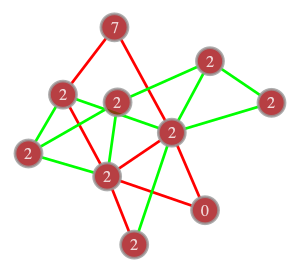

In [69]:
g = gen_balanced_type(Balance.WEAKLY, n=10, m=2)

print(test_graph_balance(g))
draw_cluster_graph(g)

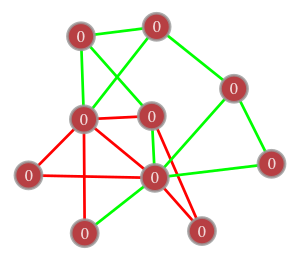

In [70]:
draw_cluster_graph_nick(g)

In [54]:
-(adjacency_mat(g) - 1)

array([[ 1., -0., -0.,  1.,  1., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0.,  1.,  1.,  1.,  1.,  1.,  1.],
       [-0., -0.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.],
       [ 1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1., -0., -0.,  1., -0.,  1.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.,  1.],
       [-0.,  1., -0.,  1.,  1.,  1.,  1., -0.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1.],
       [-0.,  1.,  1.,  1.,  1., -0.,  1.,  1.,  1., -0.],
       [-0.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -0.,  1.]])

In [52]:
friendliness_mat(g)

array([[ 0., -1., -1.,  0.,  0.,  1.,  1.,  1., -1.,  1.],
       [-1.,  0.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  1.,  0., -1.,  1.,  0., -1.,  0.,  0.,  0.],
       [ 0., -1., -1.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -1.,  0., -1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0.],
       [ 1.,  0., -1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.]])